In [1]:
import os
import sys


project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)



import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import wandb
from modules.utils import load_runs_final_artifact
from modules.models import TCN_channel, TCN, memory_polynomial_channel
from modules.utils import *
import pandas as pd
import seaborn as sns
import pickle
from matplotlib import cm
from scipy import stats
import zarr




DEVICE = torch.device("cpu")
print("DEVICE", DEVICE)
ENTITY = "dylanbackprops-university-of-washington"
PROJECT = "mldrivenpeled"

PLOT_PATH = os.path.join(project_root, "data/plots")

DEVICE cpu


In [2]:
# Set plotting variables
plt.rcParams.update({
    'font.size': 5,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'axes.labelsize': 5,
    'axes.titlesize': 7,
    'xtick.labelsize': 5,
    'ytick.labelsize': 5,
    'legend.fontsize': 5,
    'figure.dpi': 300,
    'lines.linewidth': 1.0,
    'lines.markersize': 4,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'axes.linewidth': 0.8
    })

sns.set_style("whitegrid")

plt.rcParams.update({
    "axes.spines.top": True,
    "axes.spines.right": True,
    "axes.spines.left": True,
    "axes.spines.bottom": True,
    "axes.edgecolor": "black",
    "axes.linewidth": 0.8,
})

# Setup for a standard 1-column Nature figure
mm_to_inches = 1 / 25.4
fig_width = 88 * mm_to_inches  # 3.46 inches
fig_height = 88 * mm_to_inches 

# 2 column
double_fig_width = 180 * mm_to_inches
double_fig_height = 88 * mm_to_inches  # 3.46 inches


In [3]:

models = {
    "48mA": {
        'ofdm_info': extract_zarr_data( r"../data/channel_measurements/zarr_files/channel_3e5-7.6MHz_2.68.V_0.125A_48mA_scale2_dynamic_power_0.5-3_v2.zarr", DEVICE),
        'tcn_channel': "comfy-sweep-115",
        'encoder_decoder_tcn': "volcanic-galaxy-403",
        'memory_polynomial':'blank',
        'encoder_decoder_mp':'eager-grass-413',
        'grid_search':"yqzp2ezq",
        "tcn_validation": "fancy-plant-509",
        "mp_validation": "feasible-violet-510",
        "no_noise_tcn_validation": "copper-wave-644"
    },
    "60mA": {
        'ofdm_info': extract_zarr_data( r"../data/channel_measurements/zarr_files/channel_3e5-9.2MHz_2.775.V_0.129A_60mA_scale2_dynamic_power_0.5-3.zarr", DEVICE),
        'tcn_channel': "happy-sweep-40",
        'encoder_decoder_tcn': "dazzling-wildflower-535",
        'memory_polynomial':'blank',
        'encoder_decoder_mp':'easy-yogurt-557',
        'grid_search':"jlwt6o4d",
        "tcn_validation": "stellar-water-768",
        "mp_validation": "proud-bird-769",
        "no_noise_tcn_validation":"northern-terrain-770"
    },
    "80mA": {
        'ofdm_info': extract_zarr_data( r"../data/channel_measurements/zarr_files/channel_3e5-10.8MHz_2.834V_0.135A_80mA_scale2_dynamic_power_0.5-3_v2.zarr", DEVICE),
        'tcn_channel': "classic-sweep-27",
        'encoder_decoder_tcn': "blooming-disco-648",
        'memory_polynomial':'blank',
        'encoder_decoder_mp':'cosmic-thunder-682',
        "tcn_validation": "lyric-haze-736",
        "mp_validation": "radiant-wood-740",
        "no_noise_tcn_validation":"radiant-dew-742"
    },
    "121mA": {
        'ofdm_info': extract_zarr_data( r"../data/channel_measurements/zarr_files/channel_3e5-13MHz_2.934V_0.121A_121mA_scale2_dynamic_power_0.5-3_v2.zarr", DEVICE),
        'tcn_channel': "rural-sweep-18",
        'encoder_decoder_tcn': "gentle-fog-741",
        'memory_polynomial':'blank',
        'encoder_decoder_mp':'giddy-fire-743',
        'grid_search':"tghclulb",
        "tcn_validation": "icy-snow-746",
        "mp_validation": "avid-water-751",
        "no_noise_tcn_validation":"happy-sun-757"
    },
}

wide_channel = {
        "wide channel 48mA": {
        'ofdm_info': extract_zarr_data( r"../data/channel_measurements/zarr_files/channel_3e5-15.2MHz_2.734V_0.126A_47mA_scale2_dynamic_power_0.5-3_v2.zarr", DEVICE),
        'tcn_channel': "fine-sweep-18",
        'encoder_decoder_tcn': "wobbly-jazz-801",
        'memory_polynomial':'blank',
        'encoder_decoder_mp':'deft-water-802',
        'grid_search':"bq7zffox",
        "tcn_validation": "lunar-glade-806",
        "mp_validation": "fiery-morning-810",
       "no_noise_tcn_validation": "vibrant-forest-811"
    }
}



c:\Users\maild\mldrivenpeled\modules\utils.py:74: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(cache_path, map_location=device)


Loaded from cache!
Loaded from cache!
Loaded from cache!
Loaded from cache!
Loaded from cache!


In [4]:
# Iterate over different current levels and fit memory polynomial models
for current_level, model_info in models.items():
    ofdm_info = model_info['ofdm_info']
    mp_model = memory_polynomial_channel(weights=None, memory_linear=9, memory_nonlinear=9, nonlinearity_order=2, device=torch.device('cpu'))
    _, _ , _ = mp_model.fit(ofdm_info.sent_frames_time, ofdm_info.received_frames_time)
    model_info['memory_polynomial'] = mp_model

for current_level, model_info in wide_channel.items():
    ofdm_info = model_info['ofdm_info']
    mp_model = memory_polynomial_channel(weights=None, memory_linear=9, memory_nonlinear=9, nonlinearity_order=2, device=torch.device('cpu'))
    _, _ , _ = mp_model.fit(ofdm_info.sent_frames_time, ofdm_info.received_frames_time)
    model_info['memory_polynomial'] = mp_model

In [ ]:
for current_level, model_info in models.items():
    mp_test = models[current_level]['memory_polynomial']
    ofdm_info = models[current_level]['ofdm_info']
    X, Y = ofdm_info.sent_frames_time, ofdm_info.received_frames_time
    mp_test.calculate_err(X, Y, plot=True)

KeyboardInterrupt: 

In [ ]:
X.shape

torch.Size([5573, 8000])

Loading from ../models\channel_models\comfy-sweep-115\channel_model_final.pth


c:\Users\maild\mldrivenpeled\modules\utils.py:407: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(local_weights_path, map_location="cpu")


Loading from ../models\channel_models\happy-sweep-40\channel_model_final.pth
Loading from ../models\channel_models\classic-sweep-27\channel_model_final.pth
Loading from ../models\channel_models\rural-sweep-18\channel_model_final.pth


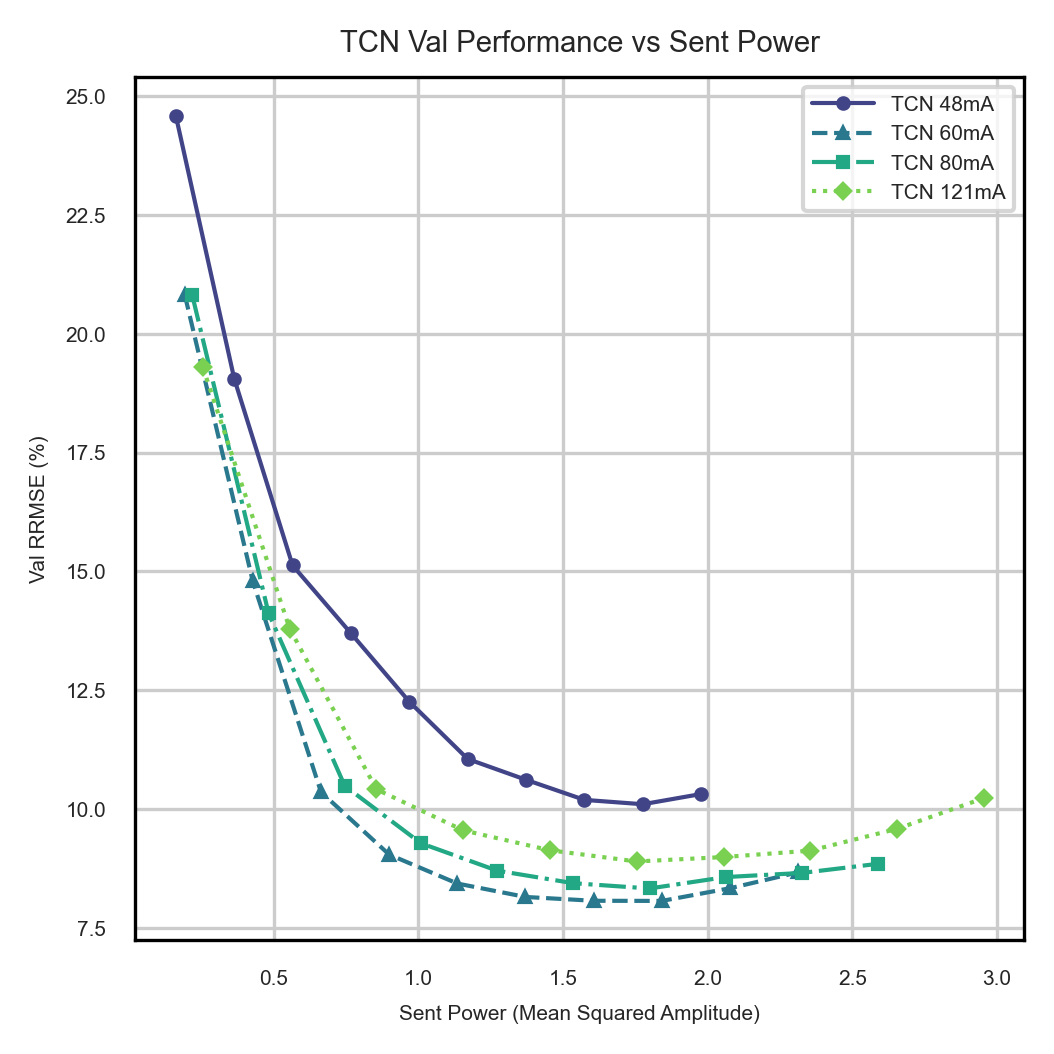

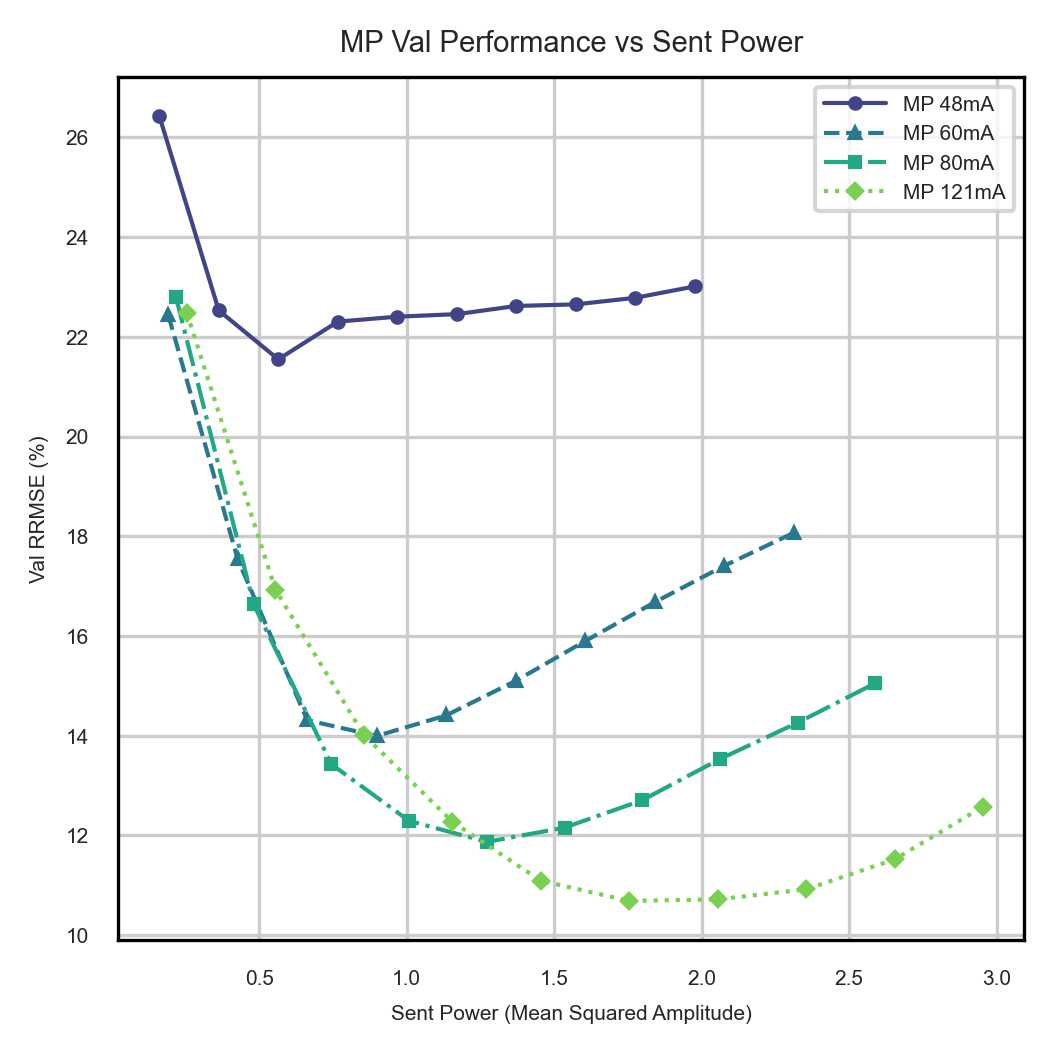

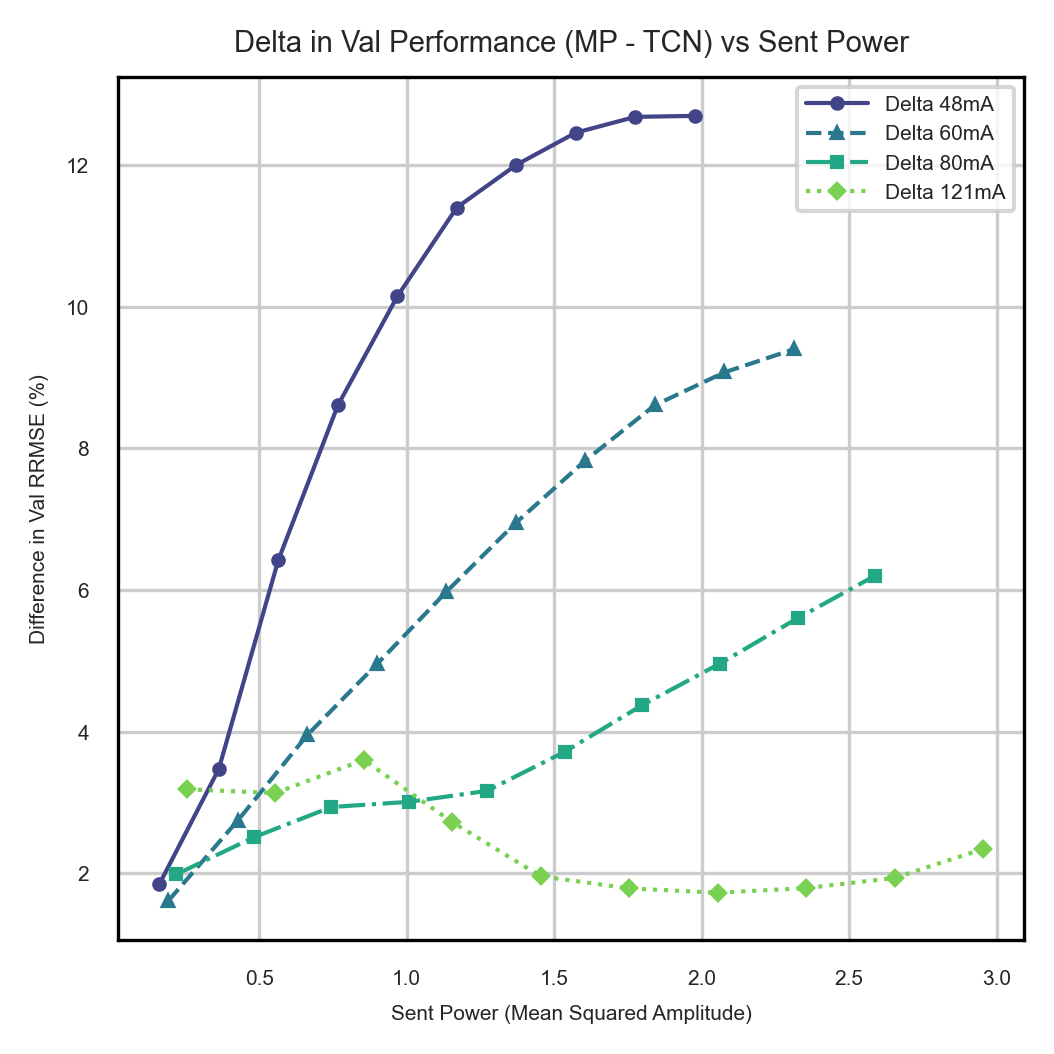

In [ ]:
plt.rcParams.update({'figure.dpi': 300})

current_levels = list(models.keys())
markers = ['o', '^', 's', 'D', 'p']
line_styles = ['-', '--', '-.', ':', '-']
num_levels = len(current_levels)
color_palette = sns.color_palette("viridis", num_levels)

all_results = {}
N = 10

for current_level, model_info in models.items():
    ofdm_info = model_info['ofdm_info']
    X = ofdm_info.sent_frames_time.to(DEVICE)
    Y = ofdm_info.received_frames_time.to(DEVICE)
    mp_model = model_info['memory_polynomial']
    tcn_model, tcn_cfg = load_runs_final_artifact(model_info['tcn_channel'], DEVICE, model_type='channel')

    sent_powers = X.square().mean(dim=-1).to(torch.float64) # Ensure float64 for precision
    pwr_min, pwr_max = sent_powers.min(), sent_powers.max()
    bins = torch.linspace(pwr_min, pwr_max, N + 1)
    bin_ids = torch.bucketize(sent_powers, bins)
    
    binned_losses = torch.zeros(N, 2)
    for i in range(N):
        mask = bin_ids == i
        if mask.any():
            filtered_x, filtered_y = X[mask], Y[mask]
            _, y_pred_tcn, _, _ = tcn_model(filtered_x)
            mp_y_pred = mp_model(filtered_x)
            binned_losses[i, 0] = calculate_rrmse_pct_loss(filtered_y, y_pred_tcn)
            binned_losses[i, 1] = calculate_rrmse_pct_loss(filtered_y, mp_y_pred)
        else:
            binned_losses[i, :] = torch.nan
            
    all_results[current_level] = {
        'bin_centers': 0.5 * (bins[:-1] + bins[1:]),
        'losses': binned_losses
    }

plt.figure(figsize=(fig_width, fig_height))
for (current_level, data), marker, line_style in zip(all_results.items(), markers, line_styles):
    plt.plot(data['bin_centers'].cpu(), data['losses'][:, 0].cpu(), color=color_palette[current_levels.index(current_level)], marker=marker, linestyle=line_style, markersize=2.5, label=f'TCN {current_level}')
plt.title("TCN Val Performance vs Sent Power")
plt.xlabel("Sent Power (Mean Squared Amplitude)")
plt.ylabel("Val RRMSE (%)")
plt.legend(fontsize=5, handlelength = 3, labelspacing=0.5)
plt.grid(True)
plt.tight_layout()

plt.savefig(
    os.path.join(PLOT_PATH, "rrmse_tcn.svg"), 
    format='svg', 
    bbox_inches='tight'
)

plt.show()


plt.figure(figsize=(fig_width, fig_height))
for (current_level, data), marker, line_style in zip(all_results.items(), markers, line_styles):
    plt.plot(data['bin_centers'].cpu(), data['losses'][:, 1].cpu(), color=color_palette[current_levels.index(current_level)], marker=marker, linestyle=line_style, markersize=2.5, label=f'MP {current_level}')
plt.title("MP Val Performance vs Sent Power")
plt.xlabel("Sent Power (Mean Squared Amplitude)")
plt.ylabel("Val RRMSE (%)")
plt.legend(fontsize=5, handlelength = 3, labelspacing=0.5)
plt.tight_layout()
plt.grid(True)


plt.savefig(
    os.path.join(PLOT_PATH, "rrmse_mp.svg"), 
    format='svg', 
    bbox_inches='tight'
)

plt.show()

plt.figure(figsize=(fig_width, fig_height))
for (current_level, data), marker, line_style in zip(all_results.items(), markers, line_styles):
    delta = data['losses'][:, 1] - data['losses'][:, 0]
    plt.plot(data['bin_centers'].cpu(), delta.cpu(), color=color_palette[current_levels.index(current_level)], marker=marker, linestyle=line_style, markersize=2.5, label=f'Delta {current_level}')
plt.title("Delta in Val Performance (MP - TCN) vs Sent Power")
plt.xlabel("Sent Power (Mean Squared Amplitude)")
plt.ylabel("Difference in Val RRMSE (%)")
plt.legend(fontsize=5, handlelength = 3, labelspacing=0.5)
plt.tight_layout()
plt.grid(True)


plt.savefig(
    os.path.join(PLOT_PATH, "rrmse_delta.svg"), 
    format='svg', 
    bbox_inches='tight'
)
plt.show()



Loading from cache!


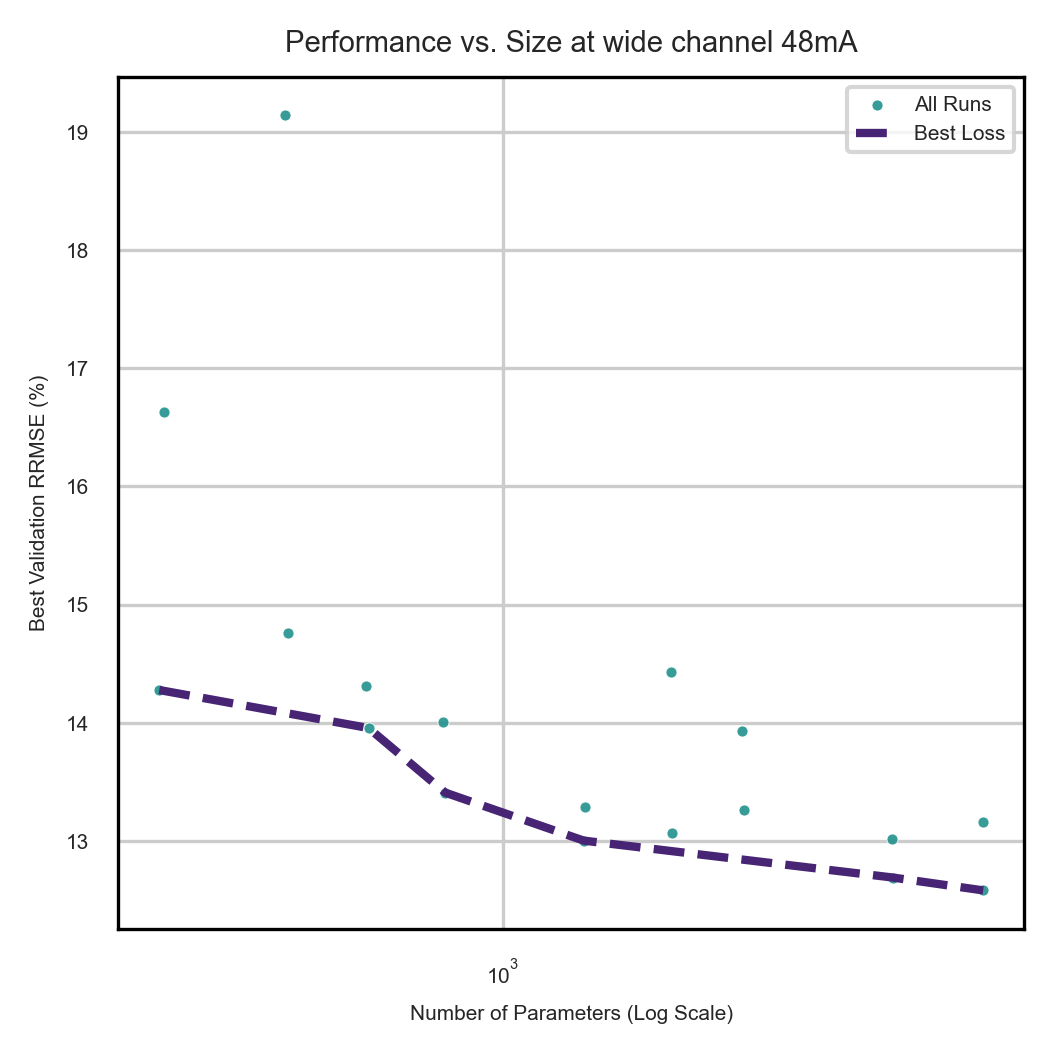

In [ ]:
#G4: Get Models for a Sweep and Plot Best Val NMRSE loss vs parameter count



cmap = plt.get_cmap("viridis")
c_runs  = cmap(0.5)
c_best = cmap(0.1)

def plot_sweep_pareto(sweep_id, entity, project):
    """
    Fetches all runs from a W&B sweep and plots Best Val NRMSE vs Parameter Count.

    Args:
        sweep_id (str): The ID of the sweep.
        entity (str): Your W&B username or team name.
        project (str): The project name.
    """

    # Check if sweep id is cached in plot data
    cache_file = f"cache_{sweep_id}.pkl"
    cache_path = os.path.join(project_root, f"data/plots/{cache_file}")
    if os.path.exists(cache_path):
        print("Loading from cache!")
        with open(cache_path, 'rb') as f:
            sweep_data = pickle.load(f)

    else:
        print("Getting from API")

        api = wandb.Api()

        path = f"{entity}/{project}/{sweep_id}"
        sweep = api.sweep(path)

        # save in pickle file
        os.makedirs(os.path.dirname(cache_path), exist_ok=True)
        sweep_data = []

        for run in sweep.runs:
            # Skip failed/crashed runs
            if run.state != "finished":
                continue
            num_params = run.config.get('num_params')

            val_nrmse = run.summary.get('avg_nrmse_pct_loss')

            sweep_data.append({
                "params": num_params,
                "nrmse_pct": val_nrmse,
                "run_name": run.name
            })

        with open(cache_path, 'wb') as f:
            pickle.dump(sweep_data, f)

    df = pd.DataFrame(sweep_data)

    df = df.sort_values("params")

    pareto_points = []
    current_min_error = float('inf')

    for _, row in df.iterrows():
        if row['nrmse_pct'] < current_min_error:
            pareto_points.append(row)
            current_min_error = row['nrmse_pct']

    pareto_df = pd.DataFrame(pareto_points)

    plt.figure(figsize=(fig_width, fig_height))

    # Scatter all runs
    sns.scatterplot(
        data=df,
        x='params',
        y='nrmse_pct',
        s=7,
        alpha=0.9,
        color=c_runs,
        label='All Runs'
    )

    # Draw Pareto Line
    plt.plot(
        pareto_df['params'],
        pareto_df['nrmse_pct'],
        linestyle='--',
        linewidth=2,
        label='Best Loss',
        color=c_best
    )

    plt.xscale('log')
    plt.xlabel('Number of Parameters (Log Scale)')
    plt.ylabel('Best Validation RRMSE (%)')
    plt.title(f'Performance vs. Size at {DC_BIAS}')
    plt.legend(loc='upper right')



DC_BIAS = 'wide channel 48mA'

SWEEP_ID = wide_channel[DC_BIAS]['grid_search']

plot_sweep_pareto(SWEEP_ID, entity=ENTITY, project=PROJECT)
plt.tight_layout()
plt.savefig(
    os.path.join(PLOT_PATH, "performance_vs_size.svg"), 
    format='svg', 
    bbox_inches='tight',
    transparent=True
)
plt.show()


No cache found, computing EVM losses and caching...
No cache found, computing EVM losses and caching...
No cache found, computing EVM losses and caching...
No cache found, computing EVM losses and caching...
Loading from ../models\encoder_decoders\volcanic-galaxy-403\time_autoencoder.pth
Loading from ../models\encoder_decoders\eager-grass-413\time_autoencoder.pth
Loading from ../models\channel_models\comfy-sweep-115\channel_model_final.pth
Loading from ../models\encoder_decoders\dazzling-wildflower-535\time_autoencoder.pth
Loading from ../models\encoder_decoders\easy-yogurt-557\time_autoencoder.pth
Loading from ../models\channel_models\happy-sweep-40\channel_model_final.pth
Loading from ../models\encoder_decoders\blooming-disco-648\time_autoencoder.pth
Loading from ../models\encoder_decoders\cosmic-thunder-682\time_autoencoder.pth
Loading from ../models\channel_models\classic-sweep-27\channel_model_final.pth
Loading from ../models\encoder_decoders\gentle-fog-741\time_autoencoder.pth
Lo

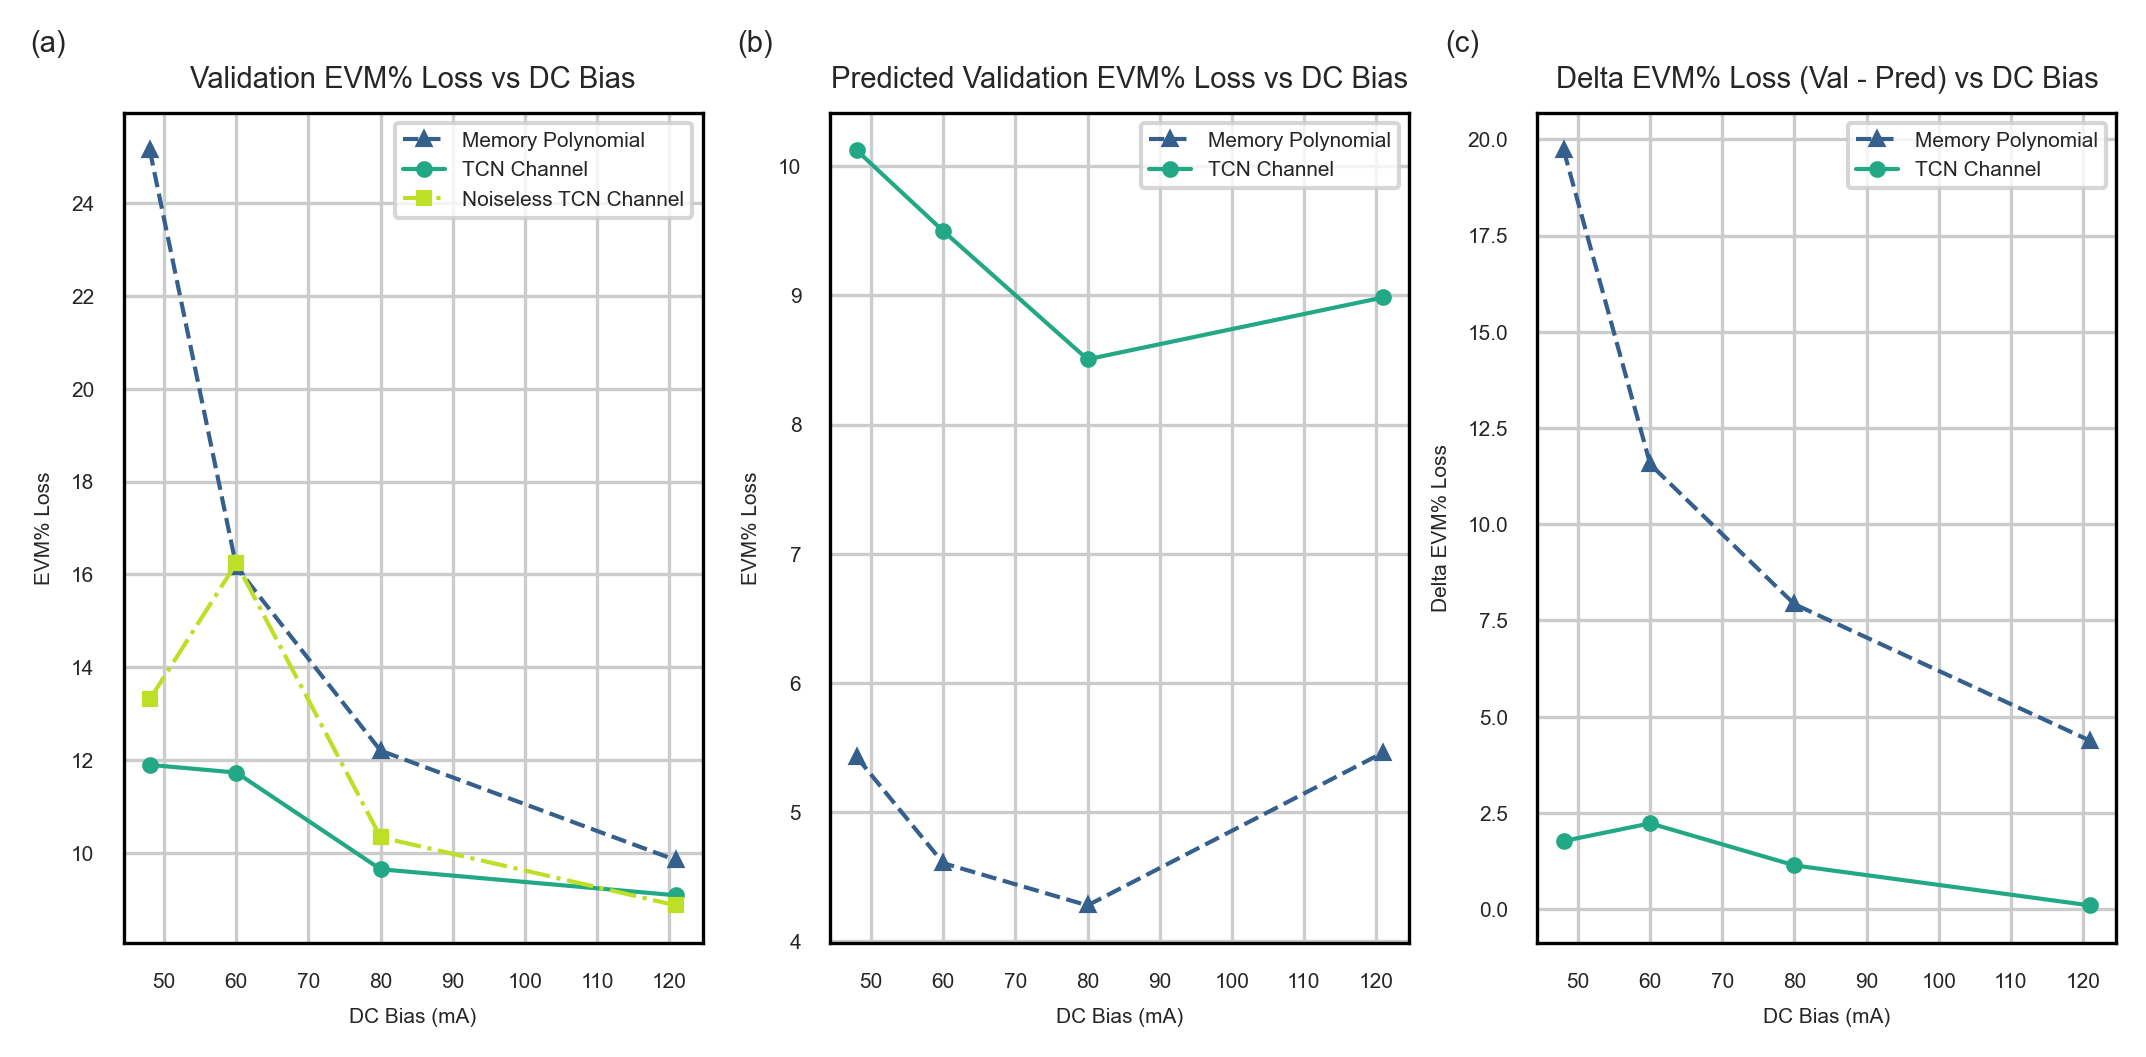

In [ ]:
# Analyze Experimental Validation Data

from scipy.fft import rfft
from lab_scripts.constellation_diagram import get_constellation


def calculate_evm_loss(sent_frames_time, decoded_frames_time, val_ofdm_settings, KS):
    sent_frames_frequency = torch.tensor(rfft(sent_frames_time[:, val_ofdm_settings.CP_LENGTH:].numpy(), norm='ortho', axis=1)[:, KS])
    decoded_frames_frequency = torch.tensor(rfft(decoded_frames_time[:, val_ofdm_settings.CP_LENGTH:].numpy(), norm='ortho', axis=1)[:, KS])
    diff_complex = sent_frames_frequency - decoded_frames_frequency
    evm_loss = torch.sqrt(torch.sum(diff_complex.abs().pow(2)) / torch.sum(sent_frames_frequency.abs().pow(2))) * 100 # EVM in percentage
    return evm_loss.item()


root_val_path = os.path.join(project_root, "data/validation_measurements")
dc_offsets= [int(bias[:-2]) for bias in models.keys()]

no_noise_tcn_evms = []


fig, axs = plt.subplots(1, 3, figsize=(double_fig_width, double_fig_height))

cmap = plt.get_cmap("viridis")
c_mp  = cmap(0.3)
c_tcn = cmap(0.6)
c_noiseless = cmap(0.9)
val_tcn_evms = []
val_mp_evms = []


def extract_val_evm_losses(dc_bias, vals, models, root_val_path, DEVICE):
    ofdm_info = models[dc_bias]['ofdm_info']
    cache_path = os.path.join(root_val_path, f"{dc_bias}_val_cache.pt")
    if os.path.exists(cache_path):
        print(f"Loading EVM losses for {dc_bias} from cache...")
        evm_results = torch.load(cache_path, map_location=DEVICE)
        return tuple(evm_results[v] for v in vals)
    print("No cache found, computing EVM losses and caching...")

    evm_vals = dict()
    for val in vals:
        val_path = os.path.join(root_val_path, f'{models[dc_bias][val]}.zarr')
        root = zarr.open(val_path, mode="r")
        evms = []
        for frame_key in root.group_keys():
            try:
                frame = root[frame_key]
                sent_frame_time = torch.tensor(frame['time_encoder_in'][:], device=DEVICE)
                received_frame_time = torch.tensor(frame['time_decoder_out'][:], device=DEVICE)
                evm = calculate_evm_loss(sent_frame_time, received_frame_time, ofdm_info, KS)
                evms.append(evm)
            except Exception as e:
                print(f"Skipping corrupted frame {frame_key}: {e}")
                pass # skip corrupted frames
        evm_vals[val] = sum(evms) / len(evms) if evms else float('nan')
    torch.save(evm_vals, cache_path)
    return tuple(evm_vals.values())

root_val_path = os.path.join(project_root, "data/validation_measurements")
vals = ['mp_validation', 'tcn_validation', 'no_noise_tcn_validation']

val_tcn_evms = []
val_mp_evms = []
no_noise_tcn_evms = []

for dc_bias in models.keys():
    val_mp_evm, val_tcn_evm, no_noise_tcn_evm = extract_val_evm_losses(dc_bias, vals, models, root_val_path, DEVICE)
    val_tcn_evms.append(val_tcn_evm)
    val_mp_evms.append(val_mp_evm)
    no_noise_tcn_evms.append(no_noise_tcn_evm)


axs[0].plot(dc_offsets, val_mp_evms, marker='^', linestyle='--', color=c_mp, label='Memory Polynomial', markersize=3)
axs[0].plot(dc_offsets, val_tcn_evms, marker='o', linestyle='-', color=c_tcn, label='TCN Channel', markersize=3)
axs[0].plot(dc_offsets, no_noise_tcn_evms, marker='s', linestyle='-.', color=c_noiseless, label='Noiseless TCN Channel', markersize=3)
axs[0].set_title(r"Validation EVM% Loss vs DC Bias")
axs[0].set_xlabel("DC Bias (mA)")
axs[0].set_ylabel(r"EVM% Loss")
axs[0].legend()

pred_tcn_evms = []
pred_mp_evms = []

PREAMBLE_MAX = 3
# Get predicted performances using the encoder-decoder models
for dc_bias in models.keys():
    ofdm_info = models[dc_bias]['ofdm_info']
    X = ofdm_info.sent_frames_time.to(DEVICE)
    KS = ofdm_info.KS


    constellation_mode = "qpsk"
    constellation = get_constellation(constellation_mode)
    NUM_BITS = len(KS) * 2 # qpsk
    # Get subset for faster evaluation
    symbols = []
    num_symbols = 500
    for batch in range(num_symbols):
        # Generate frame data
        true_bits = np.random.randint(0, 2, size=NUM_BITS)
        true_bits_str = ''.join(map(str, true_bits))
        true_symbols = torch.tensor(
            constellation.bits_to_symbols(true_bits_str),
            dtype=torch.complex64, device=DEVICE
        )
        true_frame = true_symbols.reshape(1, len(KS))


        symbols.append(true_frame)
    symbols = torch.cat(symbols, dim=0)
    sent_frames_time = symbols_to_time(symbols, ofdm_info.LEFT_PADDING_ZEROS, ofdm_info.RIGHT_PADDING_ZEROS)
    X = torch.hstack((sent_frames_time[:, -ofdm_info.CP_LENGTH:], sent_frames_time))
    tcn_enc, tcn_dec, tcn_cfg = load_runs_final_artifact(models[dc_bias]['encoder_decoder_tcn'], DEVICE, model_type='encoder_decoder')
    mp_enc, mp_dec, mp_cfg = load_runs_final_artifact(models[dc_bias]['encoder_decoder_mp'], DEVICE, model_type='encoder_decoder')
    channel_model_tcn, _ = load_runs_final_artifact(models[dc_bias]['tcn_channel'], DEVICE, model_type='channel')
    channel_model_mp = models[dc_bias]['memory_polynomial']
    with torch.no_grad():
        enc_out_tcn= tcn_enc(X)
        enc_out_tcn = torch.clip(enc_out_tcn, -PREAMBLE_MAX, PREAMBLE_MAX)
        rec_tcn, _, _, _ = channel_model_tcn(enc_out_tcn)
        y_pred_tcn = tcn_dec(rec_tcn)

        enc_out_mp= mp_enc(X)
        enc_out_mp = torch.clip(enc_out_mp, -PREAMBLE_MAX, PREAMBLE_MAX)
        rec_mp= channel_model_mp(enc_out_mp)
        y_pred_mp = mp_dec(rec_mp)

    tcn_evm = calculate_evm_loss(X, y_pred_tcn, ofdm_info, KS)
    mp_evm = calculate_evm_loss(X, y_pred_mp, ofdm_info, KS)

    pred_tcn_evms.append(tcn_evm)
    pred_mp_evms.append(mp_evm)


axs[1].plot(dc_offsets, pred_mp_evms, marker='^', linestyle='--', color=c_mp, label='Memory Polynomial', markersize=3)
axs[1].plot(dc_offsets, pred_tcn_evms, marker='o', linestyle='-', color=c_tcn, label='TCN Channel', markersize=3)
axs[1].set_title(r"Predicted Validation EVM% Loss vs DC Bias")
axs[1].set_xlabel("DC Bias (mA)")
axs[1].set_ylabel(r"EVM% Loss")
axs[1].legend() 

# Plot Delta Performance
val_minus_pred_tcn_evms = [val - pred for val, pred in zip(val_tcn_evms, pred_tcn_evms)]
val_minus_pred_mp_evms = [val - pred for val, pred in zip(val_mp_evms, pred_mp_evms)]
axs[2].plot(dc_offsets, val_minus_pred_mp_evms, marker='^', linestyle='--', color=c_mp, label='Memory Polynomial', markersize=3)
axs[2].plot(dc_offsets, val_minus_pred_tcn_evms, marker='o', linestyle='-', color=c_tcn, label='TCN Channel', markersize=3)
axs[2].set_title(r"Delta EVM% Loss (Val - Pred) vs DC Bias")
axs[2].set_xlabel("DC Bias (mA)")
axs[2].set_ylabel(r"Delta EVM% Loss")
axs[2].legend()

# Add subplot labels (a, b, c)
for i, ax in enumerate(axs):
    ax.text(-0.1, 1.1, f"({chr(97 + i)})", transform=ax.transAxes, 
            fontsize=7, va='top', ha='right')
plt.tight_layout()
plt.savefig(
    os.path.join(PLOT_PATH, "validation_evms.svg"), 
    format='svg', 
    bbox_inches='tight',
    transparent=True
)
plt.show()

In [ ]:
# Analyze Experimental Validation Data
root_val_path = os.path.join(project_root, "data/validation_measurements")
dc_offsets= [48]

no_noise_tcn_evms = []

cmap = plt.get_cmap("viridis")
c_mp  = cmap(0.3)
c_tcn = cmap(0.6)
c_noiseless = cmap(0.9)
val_tcn_evms = []
val_mp_evms = []


root_val_path = os.path.join(project_root, "data/validation_measurements")
vals = ['mp_validation', 'tcn_validation', 'no_noise_tcn_validation']

val_tcn_evms = []
val_mp_evms = []
no_noise_tcn_evms = []

for dc_bias in wide_channel.keys():
    val_mp_evm, val_tcn_evm, no_noise_tcn_evm = extract_val_evm_losses(dc_bias, vals, wide_channel, root_val_path, DEVICE)
    val_tcn_evms.append(val_tcn_evm)
    val_mp_evms.append(val_mp_evm)
    no_noise_tcn_evms.append(no_noise_tcn_evm)


pred_tcn_evms = []
pred_mp_evms = []

PREAMBLE_MAX = 3
# Get predicted performances using the encoder-decoder models
for dc_bias in wide_channel.keys():
    ofdm_info = wide_channel[dc_bias]['ofdm_info']
    X = ofdm_info.sent_frames_time.to(DEVICE)
    KS = ofdm_info.KS


    constellation_mode = "qpsk"
    constellation = get_constellation(constellation_mode)
    NUM_BITS = len(KS) * 2 # qpsk
    # Get subset for faster evaluation
    symbols = []
    num_symbols = 500
    for batch in range(num_symbols):
        # Generate frame data
        true_bits = np.random.randint(0, 2, size=NUM_BITS)
        true_bits_str = ''.join(map(str, true_bits))
        true_symbols = torch.tensor(
            constellation.bits_to_symbols(true_bits_str),
            dtype=torch.complex64, device=DEVICE
        )
        true_frame = true_symbols.reshape(1, len(KS))


        symbols.append(true_frame)
    symbols = torch.cat(symbols, dim=0)
    sent_frames_time = symbols_to_time(symbols, ofdm_info.LEFT_PADDING_ZEROS, ofdm_info.RIGHT_PADDING_ZEROS)
    X = torch.hstack((sent_frames_time[:, -ofdm_info.CP_LENGTH:], sent_frames_time))
    tcn_enc, tcn_dec, tcn_cfg = load_runs_final_artifact(wide_channel[dc_bias]['encoder_decoder_tcn'], DEVICE, model_type='encoder_decoder')
    mp_enc, mp_dec, mp_cfg = load_runs_final_artifact(wide_channel[dc_bias]['encoder_decoder_mp'], DEVICE, model_type='encoder_decoder')
    channel_model_tcn, _ = load_runs_final_artifact(wide_channel[dc_bias]['tcn_channel'], DEVICE, model_type='channel')
    channel_model_mp = wide_channel[dc_bias]['memory_polynomial']
    with torch.no_grad():
        enc_out_tcn= tcn_enc(X)
        enc_out_tcn = torch.clip(enc_out_tcn, -PREAMBLE_MAX, PREAMBLE_MAX)
        rec_tcn, _, _, _ = channel_model_tcn(enc_out_tcn)
        y_pred_tcn = tcn_dec(rec_tcn)

        enc_out_mp= mp_enc(X)
        enc_out_mp = torch.clip(enc_out_mp, -PREAMBLE_MAX, PREAMBLE_MAX)
        rec_mp= channel_model_mp(enc_out_mp)
        y_pred_mp = mp_dec(rec_mp)


    tcn_evm = calculate_evm_loss(X, y_pred_tcn, ofdm_info, KS)
    mp_evm = calculate_evm_loss(X, y_pred_mp, ofdm_info, KS)

    pred_tcn_evms.append(tcn_evm)
    pred_mp_evms.append(mp_evm)


# print results
print(f"Wide Channel 48mA Validation Results: MP EVM: {val_mp_evms[0]:.3e}, TCN EVM: {val_tcn_evms[0]:.3e}, Noiseless TCN EVM: {no_noise_tcn_evms[0] :.3e}")
print(f"Predicted Results: MP EVM: {pred_mp_evms[0]:.3e}, TCN EVM: {pred_tcn_evms[0]:.3e}")
print(f"Delta Val - Pred: MP EVM: {val_mp_evms[0] - pred_mp_evms[0]:.3e}, TCN EVM: {val_tcn_evms[0] - pred_tcn_evms[0]:.3e}")

No cache found, computing EVM losses and caching...
Loading from ../models\encoder_decoders\wobbly-jazz-801\time_autoencoder.pth
Loading from ../models\encoder_decoders\deft-water-802\time_autoencoder.pth
Loading from ../models\channel_models\fine-sweep-18\channel_model_final.pth
Wide Channel 48mA Validation Results: MP EVM: 2.759e+01, TCN EVM: 1.834e+01, Noiseless TCN EVM: 1.837e+01
Predicted Results: MP EVM: 7.156e+00, TCN EVM: 1.670e+01
Delta Val - Pred: MP EVM: 2.044e+01, TCN EVM: 1.638e+00


Working on 48mA. . .
Loading from ../models\channel_models\comfy-sweep-115\channel_model_final.pth
Working on 60mA. . .
Loading from ../models\channel_models\happy-sweep-40\channel_model_final.pth
Working on 80mA. . .
Loading from ../models\channel_models\classic-sweep-27\channel_model_final.pth
Working on 121mA. . .
Loading from ../models\channel_models\rural-sweep-18\channel_model_final.pth


C:\Users\maild\AppData\Local\Temp\ipykernel_14580\2312918381.py:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[1, 1, 1, 1]) # Adjust rect to make room for suptitle


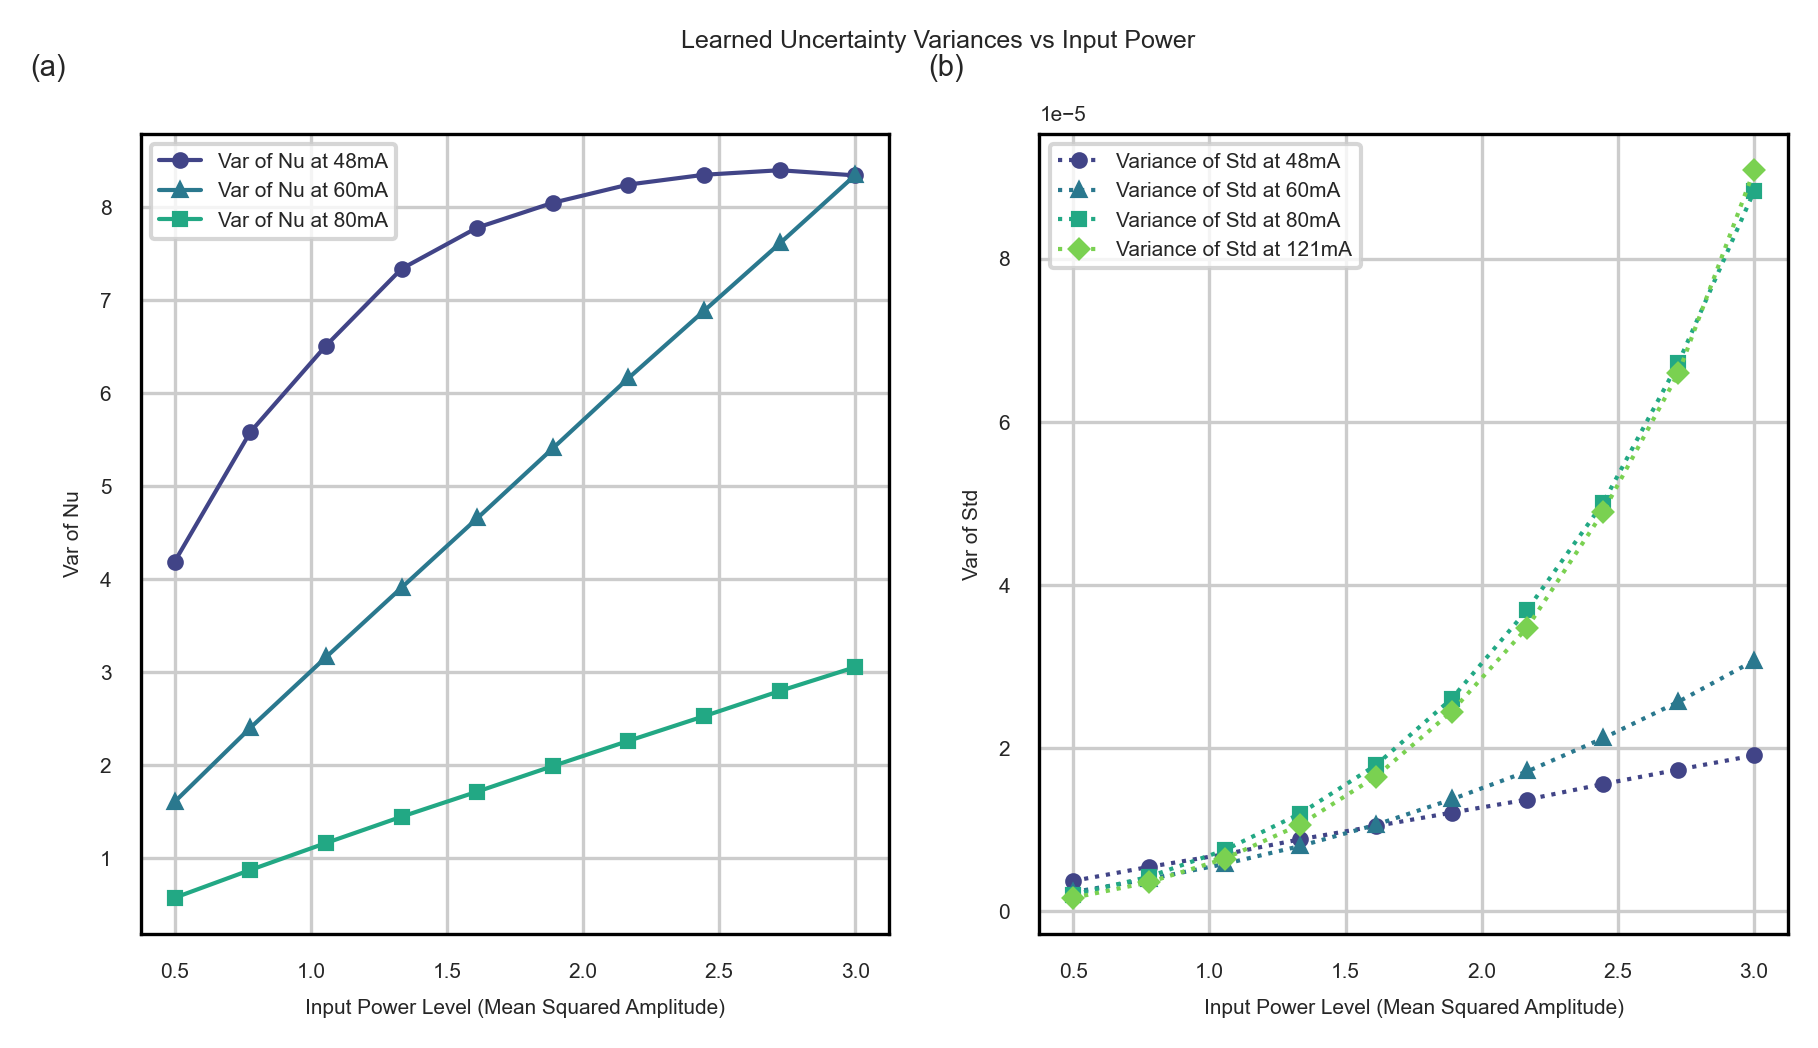

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(double_fig_width, double_fig_height))

power_levels = torch.linspace(0.5, 3.0, steps=10)

current_levels = list(models.keys())
num_levels = len(current_levels)
color_palette = sns.color_palette('viridis', num_levels)
markers = ['o', '^', 's', 'D', 'p']
line_styles = ['-', ':']
for dc_bias in models.keys():
    print(f'Working on {dc_bias}. . .')
    tcn, _ = load_runs_final_artifact(models[dc_bias]['tcn_channel'], DEVICE, model_type='channel')
    std_variances = []
    if not tcn.gaussian:
        nu_variances = []


    for power in power_levels:
        input_signal = torch.randn(1000, 1000).to(DEVICE) * torch.sqrt(power)
        noisy_y_pred, y_pred_tcn, std_y_pred, nu_y_pred = tcn(input_signal)


        # Trim by 2x receptive field to avoid edge effects
        receptive_field = tcn.receptive_field
        nu_y_pred = nu_y_pred[:, receptive_field:]
        std_y_pred = std_y_pred[:, receptive_field:]

        var_nu_y_pred = torch.var(nu_y_pred, dim=-1).mean(dim=0).cpu().item()
        var_std_y_pred = torch.var(std_y_pred, dim=-1).mean(dim=0).cpu().item()
        if not tcn.gaussian:
            nu_variances.append(var_nu_y_pred)
        std_variances.append(var_std_y_pred)

    if not tcn.gaussian:
        line1, = axs[0].plot(power_levels.cpu(), nu_variances, marker=markers[current_levels.index(dc_bias)],
                        label=f'Var of Nu at {dc_bias}', color=color_palette[current_levels.index(dc_bias)],
                        linestyle=line_styles[0], markersize=3)

    line2, = axs[1].plot(power_levels.cpu(), std_variances, marker=markers[current_levels.index(dc_bias)],
                    label=f'Variance of Std at {dc_bias}', color=color_palette[current_levels.index(dc_bias)],
                    linestyle=line_styles[1], markersize=3)
    


# This is the key line: it hides the 1e-5 at the top
axs[0].legend(loc="upper left")
axs[1].legend(loc="upper left")
axs[0].set_ylabel('Var of Nu')
axs[0].tick_params(axis='y')
axs[1].set_ylabel('Var of Std')
axs[1].tick_params(axis='y')
fig.suptitle('Learned Uncertainty Variances vs Input Power')

# Add subplot labels (a, b, c)
for i, ax in enumerate(axs):
    ax.text(-0.1, 1.1, f"({chr(97 + i)})", transform=ax.transAxes, 
            fontsize=7, va='top', ha='right')
plt.tight_layout(rect=[1, 1, 1, 1]) # Adjust rect to make room for suptitle
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('Input Power Level (Mean Squared Amplitude)')
axs[1].set_xlabel('Input Power Level (Mean Squared Amplitude)')
plt.savefig(
    os.path.join(PLOT_PATH, "learned_uncertainty_variances.svg"), 
    format='svg', 
    bbox_inches='tight',
    transparent=True
)
plt.show()

Working on 48mA. . .
Loading from ../models\channel_models\comfy-sweep-115\channel_model_final.pth
Working on 60mA. . .
Loading from ../models\channel_models\happy-sweep-40\channel_model_final.pth
Working on 80mA. . .
Loading from ../models\channel_models\classic-sweep-27\channel_model_final.pth
Working on 121mA. . .
Loading from ../models\channel_models\rural-sweep-18\channel_model_final.pth


C:\Users\maild\AppData\Local\Temp\ipykernel_14580\2236490162.py:58: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[1, 1, 1, 1]) # Adjust rect to make room for suptitle


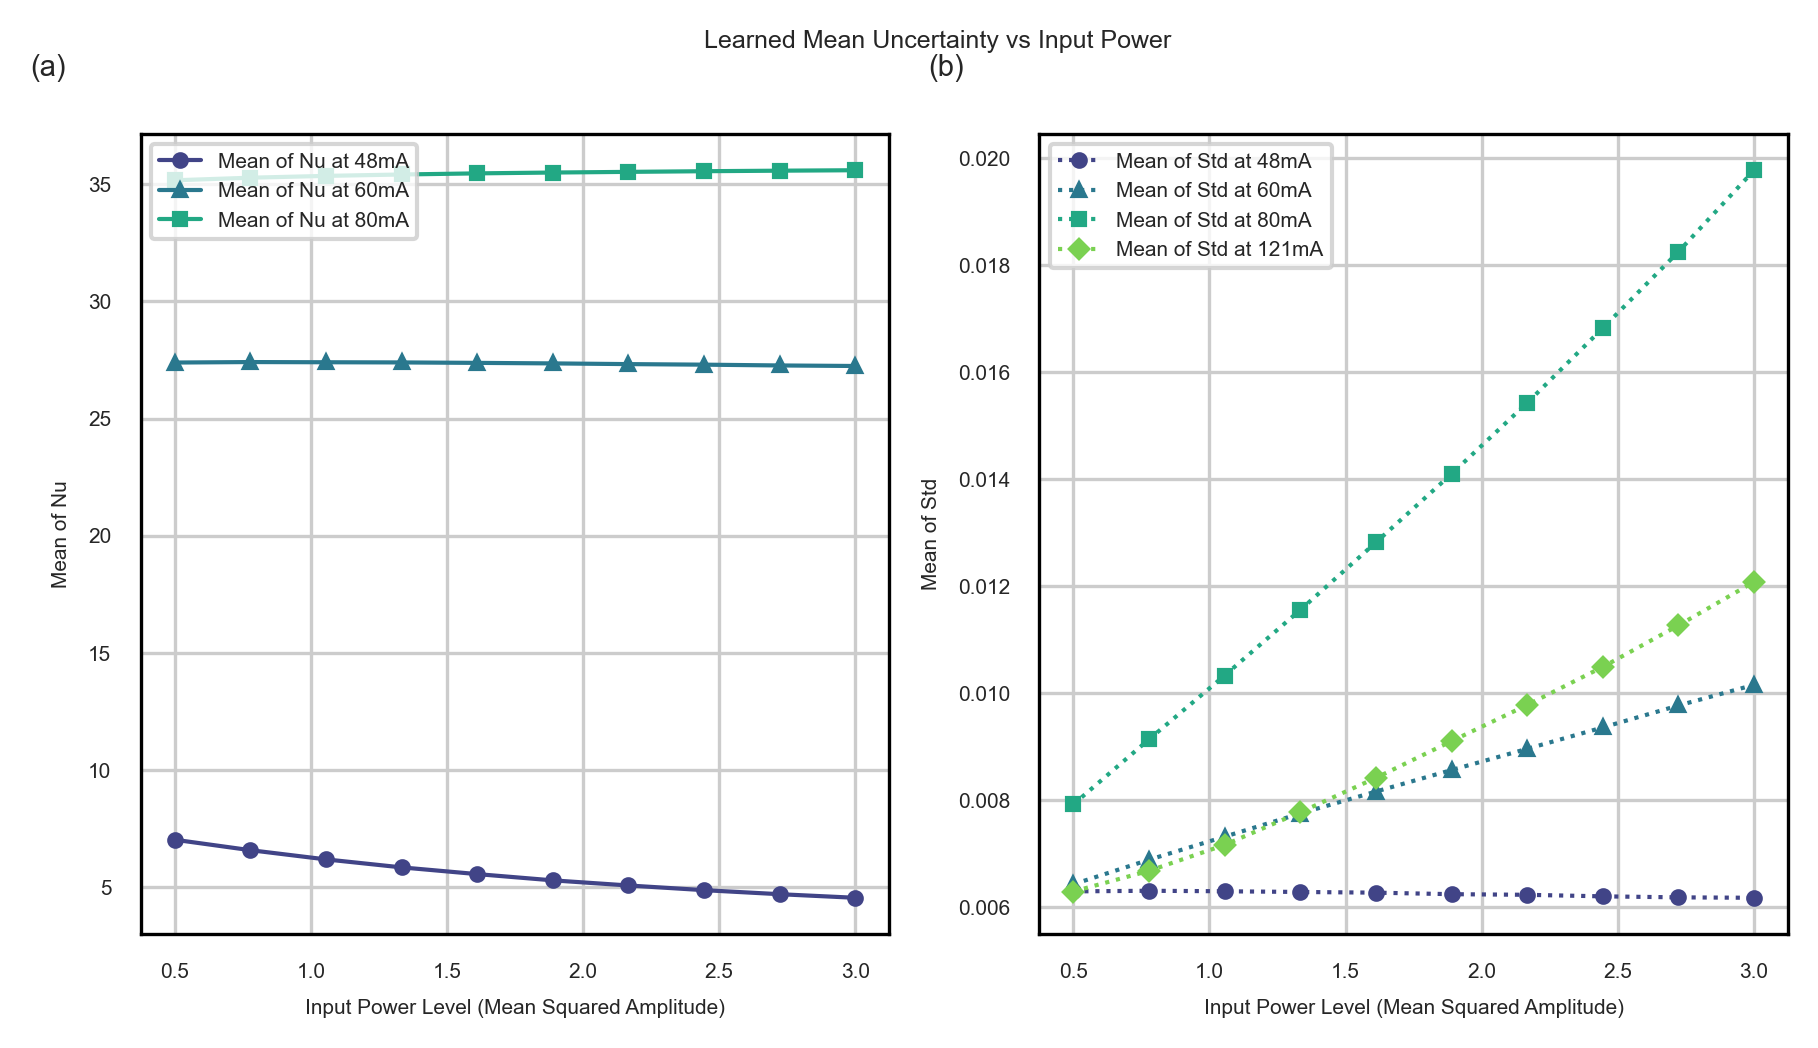

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(double_fig_width, double_fig_height))

power_levels = torch.linspace(0.5, 3.0, steps=10)

current_levels = list(models.keys())
num_levels = len(current_levels)
color_palette = sns.color_palette('viridis', num_levels)
markers = ['o', '^', 's', 'D', 'p']
line_styles = ['-', ':']
for dc_bias in models.keys():
    print(f'Working on {dc_bias}. . .')
    tcn, _ = load_runs_final_artifact(models[dc_bias]['tcn_channel'], DEVICE, model_type='channel')
    std_variances = []
    if not tcn.gaussian:
        nu_variances = []


    for power in power_levels:
        input_signal = torch.randn(1000, 1000).to(DEVICE) * torch.sqrt(power)
        noisy_y_pred, y_pred_tcn, std_y_pred, nu_y_pred = tcn(input_signal)


        # Trim by 2x receptive field to avoid edge effects
        receptive_field = tcn.receptive_field
        nu_y_pred = nu_y_pred[:, receptive_field:]
        std_y_pred = std_y_pred[:, receptive_field:]

        var_nu_y_pred = torch.mean(nu_y_pred).cpu().item()
        var_std_y_pred = torch.mean(std_y_pred).cpu().item()
        if not tcn.gaussian:
            nu_variances.append(var_nu_y_pred)
        std_variances.append(var_std_y_pred)

    if not tcn.gaussian:
        line1, = axs[0].plot(power_levels.cpu(), nu_variances, marker=markers[current_levels.index(dc_bias)],
                label=f'Mean of Nu at {dc_bias}', color=color_palette[current_levels.index(dc_bias)],
                        linestyle=line_styles[0], markersize=3)

    line2, = axs[1].plot(power_levels.cpu(), std_variances, marker=markers[current_levels.index(dc_bias)],
                    label=f'Mean of Std at {dc_bias}', color=color_palette[current_levels.index(dc_bias)],
                    linestyle=line_styles[1], markersize=3)
    


# This is the key line: it hides the 1e-5 at the top
axs[0].legend(loc="upper left")
axs[1].legend(loc="upper left")
axs[0].set_ylabel('Mean of Nu')
axs[0].tick_params(axis='y')
axs[1].set_ylabel('Mean of Std')
axs[1].tick_params(axis='y')
fig.suptitle('Learned Mean Uncertainty vs Input Power')

# Add subplot labels (a, b, c)
for i, ax in enumerate(axs):
    ax.text(-0.1, 1.1, f"({chr(97 + i)})", transform=ax.transAxes, 
            fontsize=7, va='top', ha='right')
plt.tight_layout(rect=[1, 1, 1, 1]) # Adjust rect to make room for suptitle
axs[0].grid(True)
axs[1].grid(True)
axs[0].set_xlabel('Input Power Level (Mean Squared Amplitude)')
axs[1].set_xlabel('Input Power Level (Mean Squared Amplitude)')
plt.savefig(
    os.path.join(PLOT_PATH, "learned_mean_uncertainty.svg"), 
    format='svg', 
    bbox_inches='tight',
    transparent=True
)
plt.show()

Loading from ../models\channel_models\comfy-sweep-115\channel_model_final.pth


c:\Users\maild\mldrivenpeled\modules\utils.py:407: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(local_weights_path, map_location="cpu")


Loading from ../models\channel_models\happy-sweep-40\channel_model_final.pth
Loading from ../models\channel_models\classic-sweep-27\channel_model_final.pth
Loading from ../models\channel_models\rural-sweep-18\channel_model_final.pth


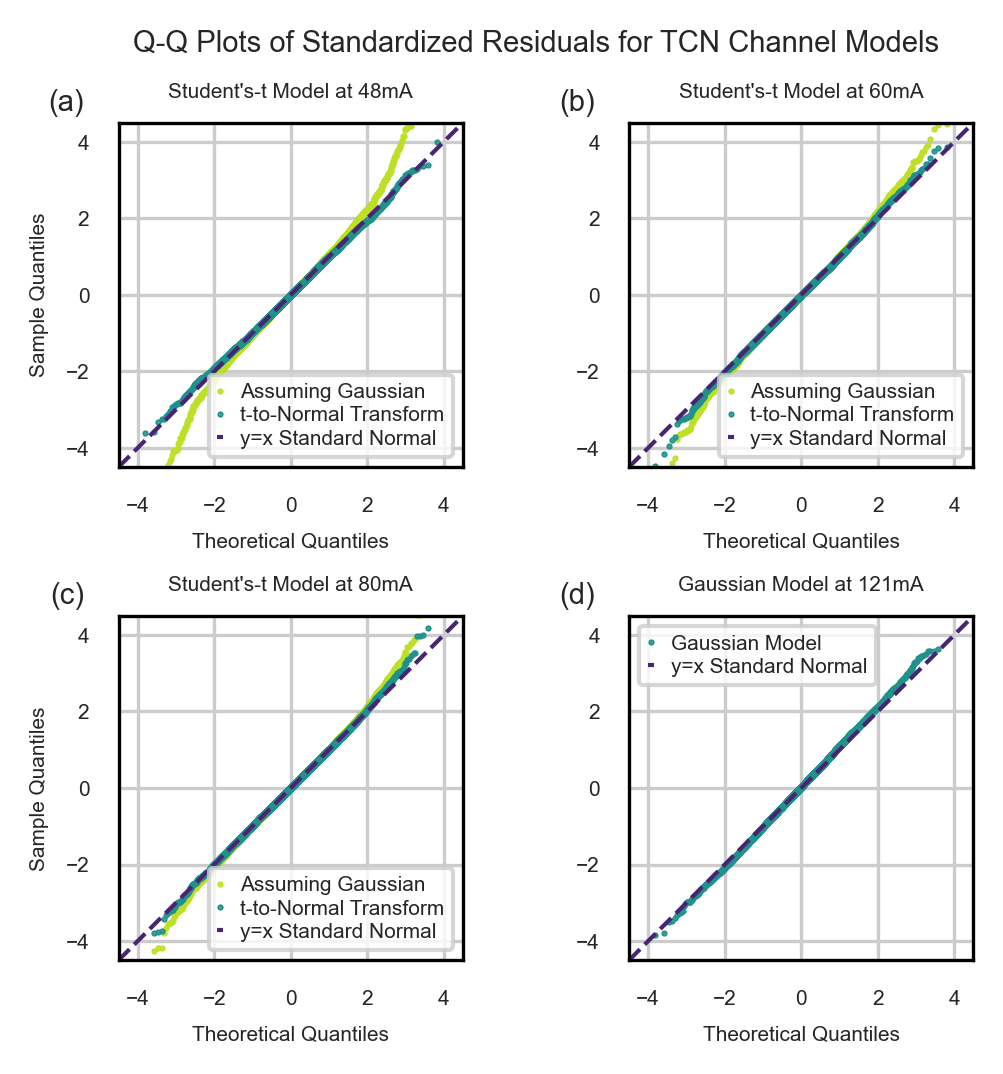

In [ ]:
fig, axs =plt.subplots(2, 2, figsize=(fig_width, fig_height), constrained_layout=True)
plt.suptitle("Q-Q Plots of Standardized Residuals for TCN Channel Models", fontsize=7)
axes = (axs[0,0], axs[0,1], axs[1,0], axs[1,1])
iter = 0
for (dc_bias, ax) in zip(models.keys(), axes):
    tcn, _ = load_runs_final_artifact(models[dc_bias]['tcn_channel'], DEVICE, model_type='channel')
    ofdm_info = models[dc_bias]['ofdm_info']

    # If model is Gaussian, plot Q-Q plot of residuals. Otherwise, for the Student's-t
    # model, we need to do a probability integral transform to get to a Gaussian using the CDF


    X, Y = ofdm_info.sent_frames_time, ofdm_info.received_frames_time
    y_pred_noisy, y_pred_mean, y_pred_std, nu = tcn(X)

    # collect residuals
    r = (Y - y_pred_mean) / y_pred_std

    # trim by receptive field
    r = r[:, tcn.receptive_field:].detach().cpu().numpy().flatten()

    nu = nu[:, tcn.receptive_field:].detach().cpu().numpy().flatten()

    # truncate to smaller amount for computational feasibility
    N = r.shape[0]
    MAX_SAMPLES = 10000
    indices = torch.randperm(N)[:MAX_SAMPLES]
    r = r[indices]
    nu = nu[indices]
    if tcn.gaussian:
        (osm, osr), _ = stats.probplot(r, dist="norm")
        ax.plot(osm, osr, marker='.', linestyle='none', color=cmap(0.5), label='Gaussian Model', rasterized=True, markersize=1)
        ax.plot([-4.5, 4.5], [-4.5, 4.5], color=cmap(0.1), linestyle='--', label='y=x Standard Normal')
        ax.set_xlim([-4.5, 4.5])
        ax.set_ylim([-4.5, 4.5]) 
        ax.set_title(f"Gaussian Model at {dc_bias}", fontsize=5)
        ax.set_xlabel("Theoretical Quantiles")
        if iter % 2 != 0:
            ax.set_ylabel("")
        else:
            ax.set_ylabel("Sample Quantiles")
        ax.grid(True)
        ax.set_box_aspect(1)
        ax.legend(fontsize=5,
            handlelength=0.3,
            labelspacing=0.2)
    else:

        # Also plot assuming just gaussian for comparison
        (osm, osr), _ = stats.probplot(r, dist="norm")
        ax.plot(osm, osr, marker='.', linestyle='none', color=cmap(0.9), label='Assuming Gaussian', markersize=1, rasterized=True)

        ax.grid(True)

        # For Student's-t, do probability integral transform
        cdf_values = stats.t.cdf(r, df=nu)
        transformed_residuals = stats.norm.ppf(cdf_values) # Transform to standard normal using inverse CDF of normal
        (osm, osr), _ = stats.probplot(transformed_residuals, dist="norm")



        ax.plot(osm, osr, marker='.', linestyle='none', color=cmap(0.5), label='t-to-Normal Transform', rasterized=True, markersize=1)
        ax.plot([-4.5, 4.5], [-4.5, 4.5], color=cmap(0.1), linestyle='--', label='y=x Standard Normal')
        ax.set_xlim([-4.5, 4.5])
        ax.set_ylim([-4.5, 4.5]) 
        ax.set_title(f"Student's-t Model at {dc_bias}", fontsize=5)
        ax.set_xlabel("Theoretical Quantiles")
        ax.legend(fontsize=5,
            handlelength=0.3,
            labelspacing=0.2)
        if iter % 2 != 0:
            ax.set_ylabel("")
        else:
            ax.set_ylabel("Sample Quantiles")
        ax.set_box_aspect(1)


        
    iter += 1

    # Add subplot labels (a, b, c)


for i, ax in enumerate(axes):
    ax.text(-0.1, 1.1, f"({chr(97 + i)})", transform=ax.transAxes, 
            fontsize=7, va='top', ha='right')
plt.savefig(
    os.path.join(PLOT_PATH, "qq_plots_residuals.svg"), 
    format='svg', 
    bbox_inches='tight',
    transparent=True,
    dpi=300
)
plt.show()